In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import sys
sys.path.append('..')

from lib.XGB import XGB
from lib.ChurnEnsemble import ChurnEnsemble
from lib.utils import format_number, show_summary

SEED = 42
np.random.seed(SEED)

2024-06-25 21:12:10.530281: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
config = dict(
    features=[
        'employees', 'interval', 'country_es', 'country_mx', 'country_latam', 'gateway_auto',
        'plan', 'usage', 'usage_groups', 'usage_payments', 'usage_avg',
        'paid_periods', 'months', 'failed_ratio'
    ],
    params=dict(
        n=200,
        lr=1e-2,
        max_depth=16,
        stop=30,
        reg_unb=True
    )
)

min_tte = 1  # Minimum time to event for binary classification (positive if `tte` <= `min_tte`)
test_size = 0.25  # Percentage of the data to use for test/validation

In [3]:
data = pd.read_csv('../files/churn-data-fit.csv')

for col in ['tp', 'ts', 'te']:
    data[col] = pd.to_datetime(data[col])

cs = (data.sort_values(['id', 'tfs']).groupby('id')['tte'].last() < 0).value_counts().sort_index().astype(float)
print('Total Customers: {} | Censored: {} | Non-censored: {} | Censored Rate {}%'.format(
    format_number(cs.sum()),
    format_number(cs[1]),
    format_number(cs[0]),
    format_number(100 * cs[1] / cs.sum(), 2)
))

data

Total Customers: 11.069 | Censored: 2.678 | Non-censored: 8.391 | Censored Rate 24,19%


,cid,id,tp,tfs,tte,ts,te,employees,mrr,value,...,usage_avg,usage_groups_avg,usage_payments_avg,paid_periods,failed_periods,active_periods,momentum,months,failed_ratio,usage_diff
0,51b46d18c4de615d0f000019,1,2017-07-01,4.0,-1.0,2017-03-01,NaT,1,26.58,159.50,...,2.00,0.0,0.0,0.0,0.0,1.0,0.00,4.0,NaN,0.00
1,51b46d18c4de615d0f000019,1,2017-08-01,5.0,-1.0,2017-03-01,NaT,1,26.58,159.50,...,2.00,0.0,0.0,0.0,0.0,2.0,1.20,5.0,NaN,0.00
2,51b46d18c4de615d0f000019,1,2017-09-01,6.0,-1.0,2017-03-01,NaT,1,26.58,239.25,...,2.00,0.0,0.0,1.0,0.0,3.0,-3.14,6.0,0.0,0.00
3,51b46d18c4de615d0f000019,1,2017-10-01,7.0,-1.0,2017-03-01,NaT,1,26.58,239.25,...,1.75,0.0,0.0,1.0,0.0,3.0,-13.60,7.0,0.0,-0.75
4,51b46d18c4de615d0f000019,1,2017-11-01,8.0,-1.0,2017-03-01,NaT,1,26.58,239.25,...,1.60,0.0,0.0,1.0,0.0,3.0,-18.57,8.0,0.0,-0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201230,66633bcee489710bb6afe3d9,11065,2024-06-01,0.0,-1.0,2024-06-01,NaT,1,101.97,101.97,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
201231,666346aee489710bb6afead3,11066,2024-06-01,0.0,-1.0,2024-06-01,NaT,1,40.00,40.00,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
201232,66634aea1e0bd65a73bf4f2f,11067,2024-06-01,0.0,-1.0,2024-06-01,NaT,1,46.62,46.62,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
201233,666388b3e489710bb6b00925,11068,2024-06-01,0.0,-1.0,2024-06-01,NaT,1,60.19,60.19,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00


In [4]:
d_split = data.sort_values(['id', 'tp']).groupby('id')['tte'].last().reset_index()
d_split['censored'] = d_split['tte'] < 0

d_train, d_test = train_test_split(
    d_split,
    test_size=test_size,
    shuffle=True,
    stratify=d_split['censored'].astype(int),
    random_state=SEED
)

cs_train = d_train['censored'].value_counts().sort_index().astype(float)
cs_test = d_test['censored'].value_counts().sort_index().astype(float)

print('Total Customers: {} ({}% censored) | Train: {} ({}%) | Test: {} ({}%)'.format(
    format_number(len(d_split)),
    format_number(100 * cs[1] / cs.sum(), 2),
    format_number(len(d_train)),
    format_number(100 * cs_train[1] / cs_train.sum(), 2),
    format_number(len(d_test)),
    format_number(100 * cs_test[1] / cs_test.sum(), 2)
))

Total Customers: 11.069 (24,19% censored) | Train: 8.301 (24,19%) | Test: 2.768 (24,21%)


In [5]:
# Instantiate the XGBoost model
xgb = XGB(
    features=config['features'],
    min_tte=min_tte,
    seed=SEED,
    verbose=1,
    path='../files/xgb',
    **config['params']
)

xgb.params

{'n': 200,
 'lr': 0.01,
 'max_depth': 16,
 'stop': 30,
 'metric': 'auc',
 'min_child_weight': 1,
 'gamma': 0,
 'weight_l1': 0,
 'weight_l2': 1,
 'dropout': 0.2,
 'shuffle': False,
 'reg_unb': True}

In [6]:
# Select train data
d_xgb_train = data[data['id'].isin(d_train['id'])].sort_values(['id', 'tfs'])[
    ['id', 'tfs', 'tte'] + xgb.features
]

# Build train tensor
x_xgb_train, y_xgb_train = xgb.build_seq(d_xgb_train)
df_xgb_train = xgb.seq_to_df(x_xgb_train, y_xgb_train)

show_summary(df_xgb_train, xgb.tgt_col)
df_xgb_train

Shape: 150,660 x 17
    0.0: 138,110 (91.67%)
    1.0: 12,550 (8.33%)


,id,tfs,tgt,employees,interval,country_es,country_mx,country_latam,gateway_auto,plan,usage,usage_groups,usage_payments,usage_avg,paid_periods,months,failed_ratio
0,1.0,4.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,2.00,0.0,4.0,NaN
1,1.0,5.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,2.00,0.0,5.0,NaN
2,1.0,6.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,2.00,1.0,6.0,0.0
3,1.0,7.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,1.75,1.0,7.0,0.0
4,1.0,8.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,1.60,1.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150655,11060.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,4.0,0.0,0.0,0.0,0.00,1.0,0.0,0.0
150656,11061.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.00,1.0,0.0,0.0
150657,11067.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.00,1.0,0.0,0.0
150658,11068.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.00,1.0,0.0,0.0


In [7]:
# Select test data
d_xgb_test = data[data['id'].isin(d_test['id'])].sort_values(['id', 'tfs'])[
    ['id', 'tfs', 'tte'] + xgb.features
]

# Build test tensor
x_xgb_test, y_xgb_test = xgb.build_seq(d_xgb_test)
df_xgb_test = xgb.seq_to_df(x_xgb_test, y_xgb_test)

show_summary(df_xgb_train, xgb.tgt_col)
df_xgb_test

Shape: 150,660 x 17
    0.0: 138,110 (91.67%)
    1.0: 12,550 (8.33%)


,id,tfs,tgt,employees,interval,country_es,country_mx,country_latam,gateway_auto,plan,usage,usage_groups,usage_payments,usage_avg,paid_periods,months,failed_ratio
0,9.0,4.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,2.0,1.0,4.0,0.00
1,9.0,5.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,2.0,2.0,5.0,0.50
2,9.0,6.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,2.0,3.0,6.0,0.33
3,9.0,7.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,2.0,3.0,7.0,0.67
4,9.0,8.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,1.8,3.0,8.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50570,11062.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00
50571,11063.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00
50572,11064.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00
50573,11065.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00


In [8]:
# Fit XGBoost model
xgb.fit(x_xgb_train, y_xgb_train, x_xgb_test, y_xgb_test)

[0]	validation_0-auc:0.92996	validation_1-auc:0.83070
[1]	validation_0-auc:0.93099	validation_1-auc:0.84627
[2]	validation_0-auc:0.94172	validation_1-auc:0.85755
[3]	validation_0-auc:0.94396	validation_1-auc:0.85925
[4]	validation_0-auc:0.94603	validation_1-auc:0.85984
[5]	validation_0-auc:0.94423	validation_1-auc:0.86006
[6]	validation_0-auc:0.94629	validation_1-auc:0.86331
[7]	validation_0-auc:0.94863	validation_1-auc:0.86252
[8]	validation_0-auc:0.95005	validation_1-auc:0.86401
[9]	validation_0-auc:0.95109	validation_1-auc:0.86350
[10]	validation_0-auc:0.95089	validation_1-auc:0.86391
[11]	validation_0-auc:0.95205	validation_1-auc:0.86469
[12]	validation_0-auc:0.95229	validation_1-auc:0.86421
[13]	validation_0-auc:0.95131	validation_1-auc:0.86433
[14]	validation_0-auc:0.95210	validation_1-auc:0.86342
[15]	validation_0-auc:0.95226	validation_1-auc:0.86520
[16]	validation_0-auc:0.95307	validation_1-auc:0.86547
[17]	validation_0-auc:0.95350	validation_1-auc:0.86635
[18]	validation_0-au

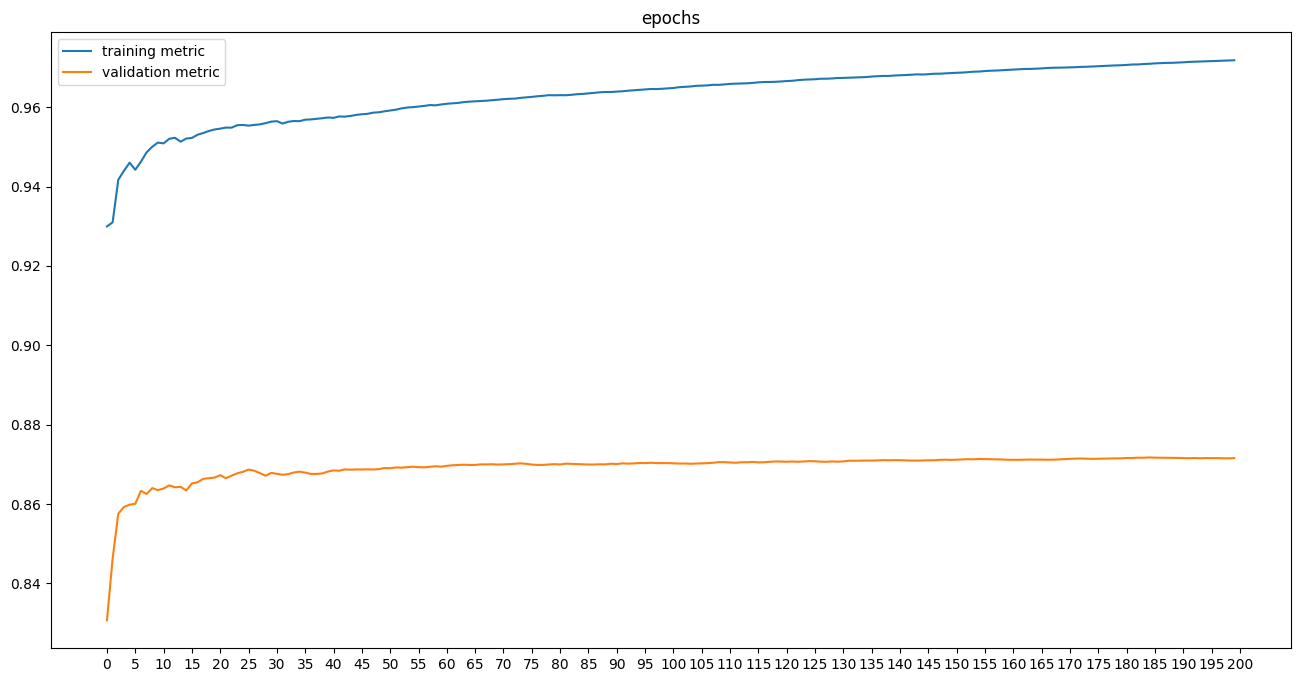

In [9]:
# Save model
xgb.save()

# Plot training history
xgb.plot_history_eval()

In [10]:
# Predict
y_xgb_hat = xgb.predict(x_xgb_test)
# Set results
xgb.set_results(y_xgb_hat, y_xgb_test)

# Prediction results
xgb.results

,id,tfs,pred,true
0,9,4,0.314106,0.0
1,9,5,0.257617,0.0
2,9,6,0.228202,0.0
3,9,7,0.290317,1.0
4,9,8,0.750591,1.0
...,...,...,...,...
50570,11062,0,0.580957,0.0
50571,11063,0,0.610475,0.0
50572,11064,0,0.711447,0.0
50573,11065,0,0.646385,0.0


In [11]:
# Get the last sequence prediction for each customer
results = (
    xgb.results
    .sort_values(['id', 'tfs'])
    .groupby('id')
    .last()
    .drop(columns=['tfs'])
    .reset_index()
)

show_summary(results, 'true')
results

Shape: 2,768 x 3
    1.0: 2,098 (75.79%)
    0.0: 670 (24.21%)


,id,pred,true
0,9,0.750591,1.0
1,10,0.341153,1.0
2,13,0.193773,1.0
3,15,0.616592,1.0
4,20,0.508301,1.0
...,...,...,...
2763,11062,0.580957,0.0
2764,11063,0.610475,0.0
2765,11064,0.711447,0.0
2766,11065,0.646385,0.0


In [12]:
# Instantiate Ensemble model in order to compute and plot the scores
model = ChurnEnsemble(
    seed=SEED,
    verbose=0,
    path='../files'
).set_data(data)
# Set the XGBoost model
model.xgb = xgb

model

In [13]:
# Compute and set model scores
model.set_scores(xgb.results)
# Set model results from XGBoost predictions
model.set_results(xgb.results)

model.results

,id,tfs,pred,true,tgt,segment,wa,wb,momentum,cid
0,9,4,0.314106,0.0,1,4,NaN,NaN,0.00,51f5447aa4dcd3245d000036
1,9,5,0.257617,0.0,1,4,NaN,NaN,0.38,51f5447aa4dcd3245d000036
2,9,6,0.228202,0.0,1,4,NaN,NaN,0.32,51f5447aa4dcd3245d000036
3,9,7,0.290317,1.0,1,4,NaN,NaN,-0.70,51f5447aa4dcd3245d000036
4,9,8,0.750591,1.0,1,5,NaN,NaN,-6.75,51f5447aa4dcd3245d000036
...,...,...,...,...,...,...,...,...,...,...
50570,11062,0,0.580957,0.0,1,5,NaN,NaN,0.00,6661e576a98733f247acc46c
50571,11063,0,0.610475,0.0,1,5,NaN,NaN,0.00,6661e7dfa98733f247acc5cd
50572,11064,0,0.711447,0.0,1,5,NaN,NaN,0.00,666227321e0bd65a73be6c31
50573,11065,0,0.646385,0.0,1,5,NaN,NaN,0.00,66633bcee489710bb6afe3d9


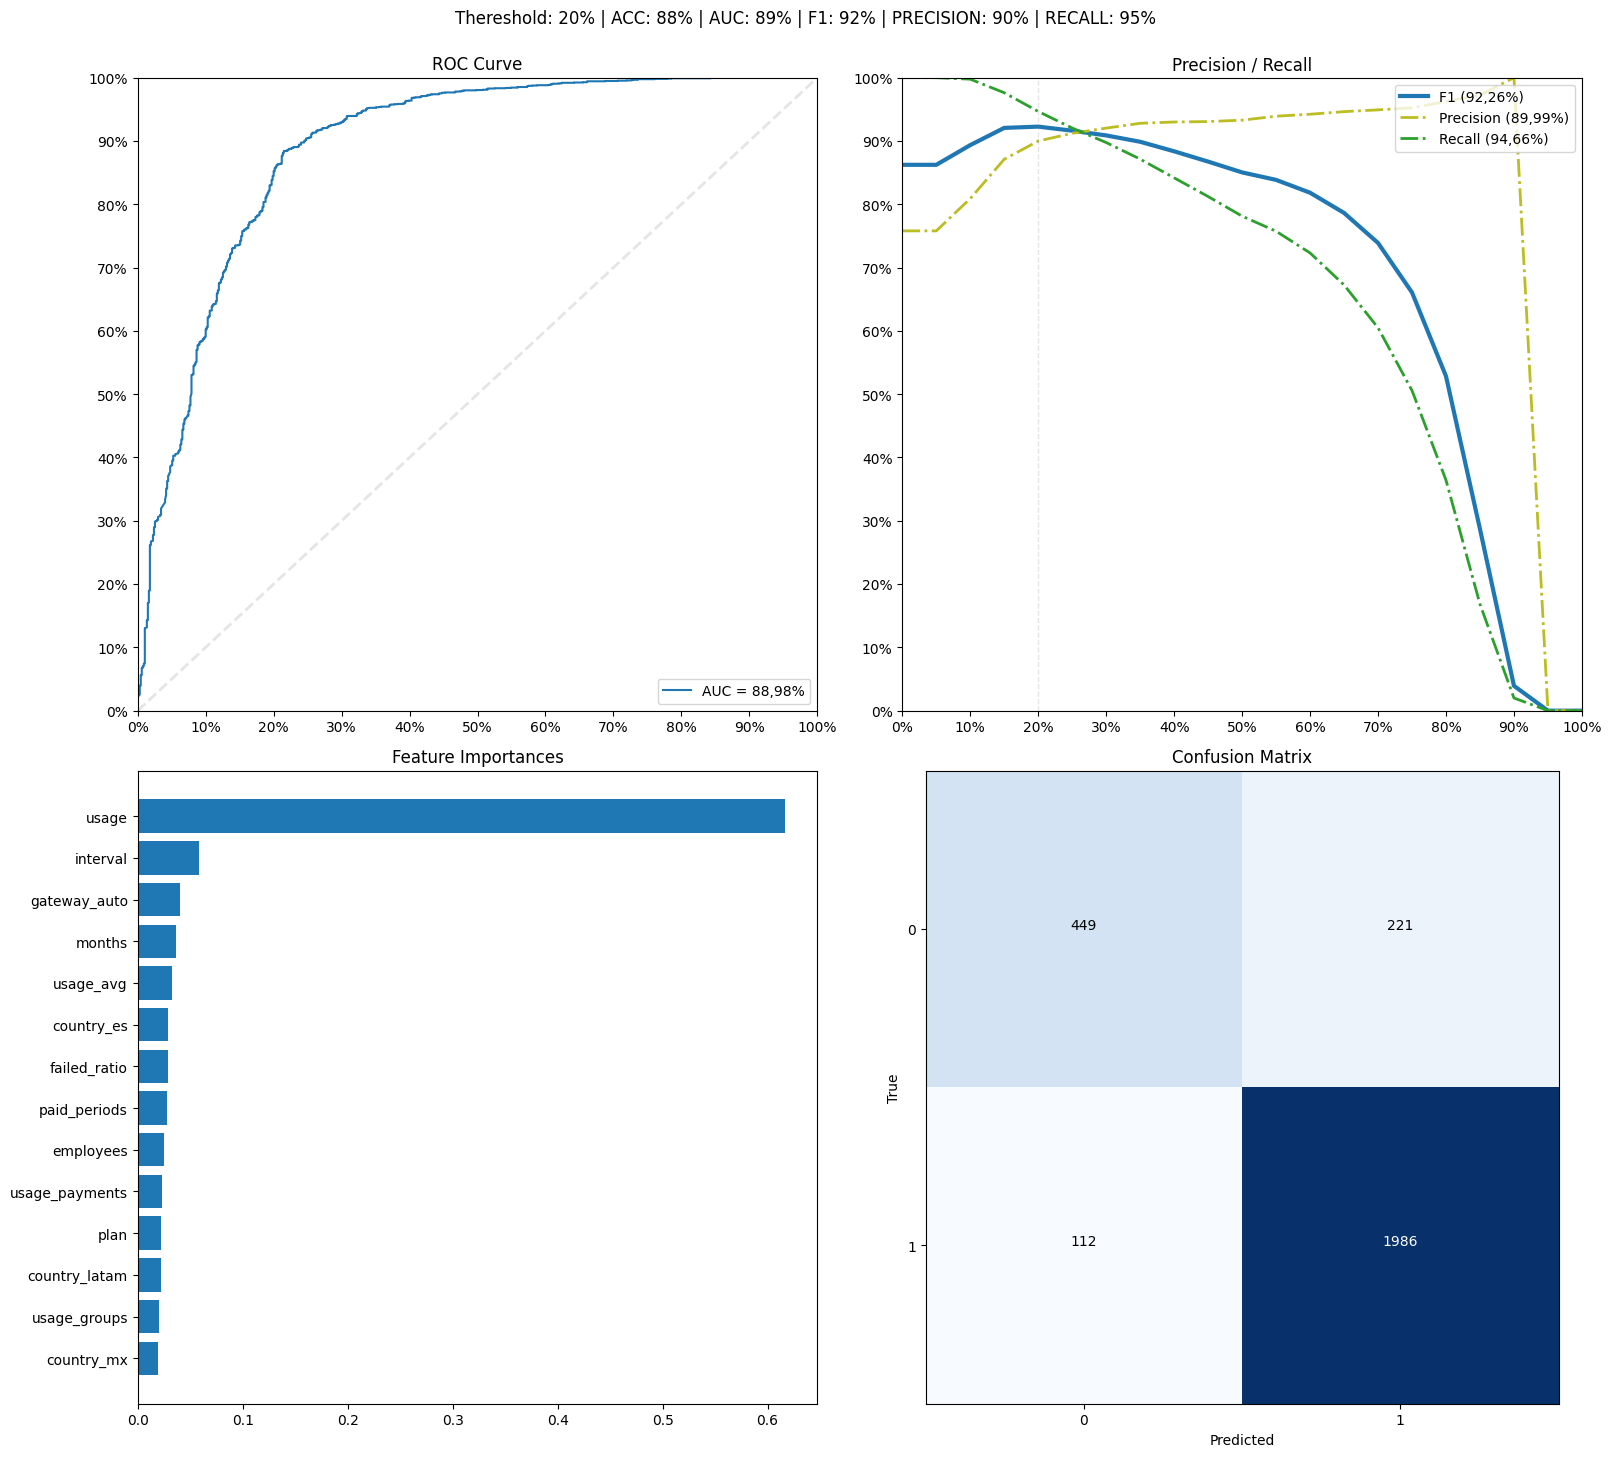

In [14]:
# Plot scores summary
model.plot_scores(xgb.results)

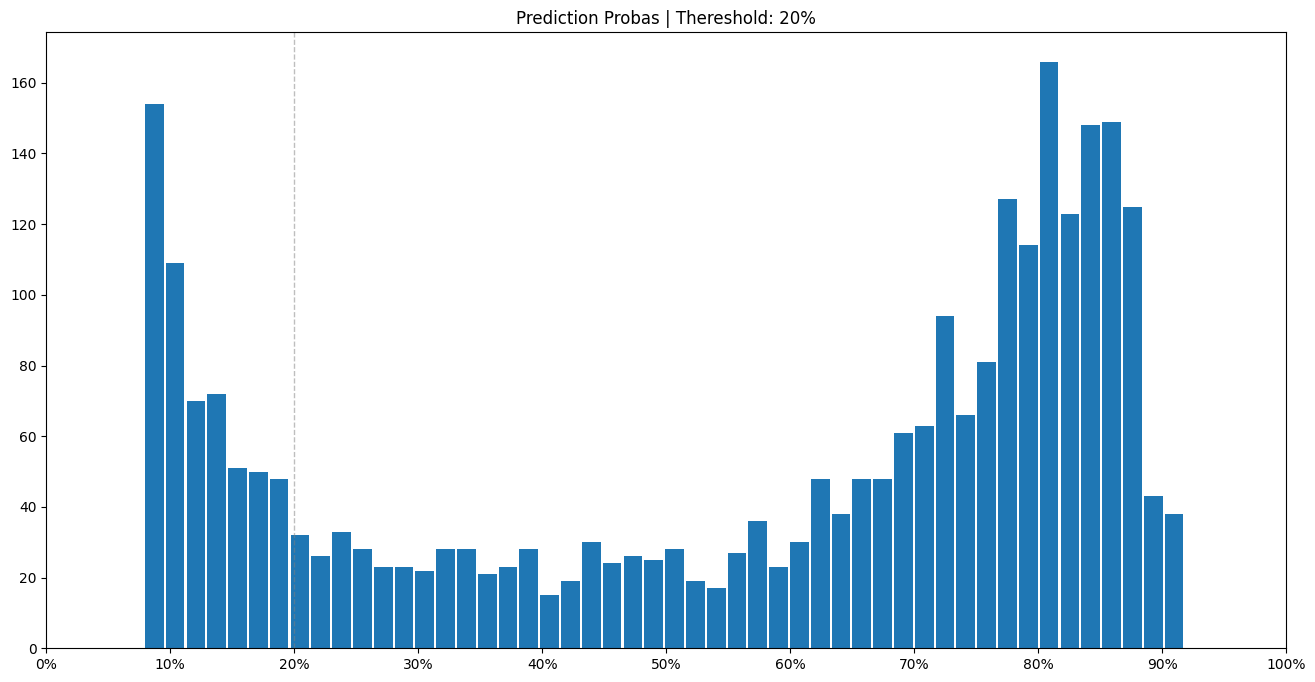

In [15]:
# Plot the histogram of the predicted probabilities for each customer sequence.
model.plot_histogram(xgb.results, loc=-1)